# Dataset

In [21]:
import torch
from torchvision import datasets, transforms
import pycocotools
import matplotlib.pyplot as plt
import numpy as np
from step_2.datasets import COCOSegmentation

In [22]:
def annToRLE(im, ann):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    h, w = im.shape[2:]
    segm = ann['segmentation']
    if type(segm) == list:
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = pycocotools.mask.frPyObjects(segm, h, w)
        rle = pycocotools.mask.merge(rles)
    elif type(segm['counts']) == list:
        # uncompressed RLE
        rle = pycocotools.mask.frPyObjects(segm, h, w)
    else:
        # rle
        rle = ann['segmentation']
    return rle

def annToMask(im, ann):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(im, ann)
    m = pycocotools.mask.decode(rle)
    return m

In [23]:
dataDir='/home/simone/SAM/COCO/'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

In [25]:
dataset = COCOSegmentation(dataDir, 'val')
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

val set
loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [4]:
dataset = datasets.CocoDetection(root = dataDir + dataType,
                                 annFile = annFile, 
                                 transform = transforms.ToTensor(), 
                                 target_transform = None,
                                 transforms = None)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4, pin_memory=True, worker_init_fn=None)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [28]:
dataset[0]

TypeError: expected str, bytes or os.PathLike object, not int

In [27]:
print(dataset[0][0]) # image
print(len(dataset[0][1])) # list of annotations
print(dataset[0][1][0].keys()) # first annotation
dataset[0][1][0]['segmentation'] # first annotation segmentation

TypeError: expected str, bytes or os.PathLike object, not int

In [6]:
for i, l in train_loader:
    print(i.shape)
    print(l[0].keys())
    break

torch.Size([1, 3, 426, 640])
dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])


/tmp/ipykernel_3466406/2312652353.py:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rles = pycocotools.mask.frPyObjects(segm, h, w)
/tmp/ipykernel_3466406/2312652353.py:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  rles = pycocotools.mask.frPyObjects(segm, h, w)


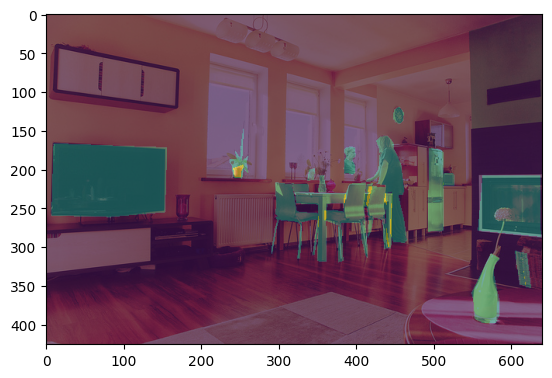

In [7]:
# Get binary mask from annotation
plt.imshow(i[0].permute(1,2,0))
m = np.zeros((i.shape[2], i.shape[3]))
for p in l:
    m += annToMask(i, p)
plt.imshow(m, alpha=0.5)
plt.show()

# Model

In [16]:
import requests

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import torch
from transformers import (SamModel, SamProcessor)

### Visualization Tools

In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(6,6))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

### Load model

In [18]:
torch.manual_seed(0)
np.random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

# Sparse SAM
# sparse = SamModel.from_pretrained("bin/90/").cuda().eval()

2023-09-26 01:42:20.657759: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 01:42:20.729151: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 01:42:20.743986: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-26 01:42:21.065851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

### Get Input Image

In [19]:
img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# plt.imshow(raw_image)
# plt.show()

### Run Inference with Prompt

In [20]:
input_points = [[[450, 600]]]
# show_points_on_image(raw_image, input_points[0])

inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])


inputs.pop("pixel_values", None) # pixel_values are no more needed
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

### Decode Output

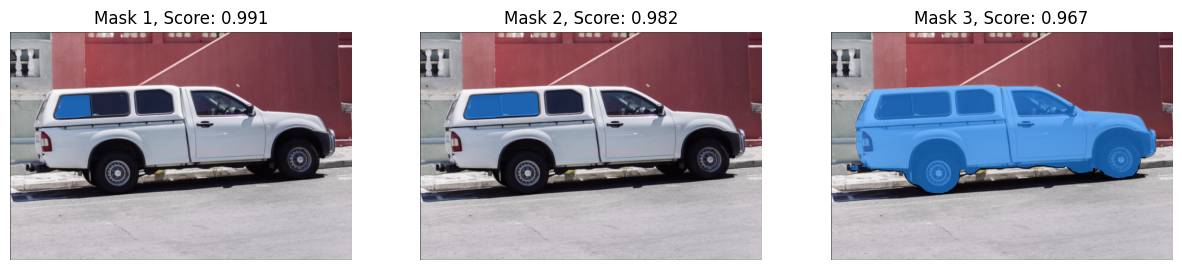

In [21]:
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks, scores)

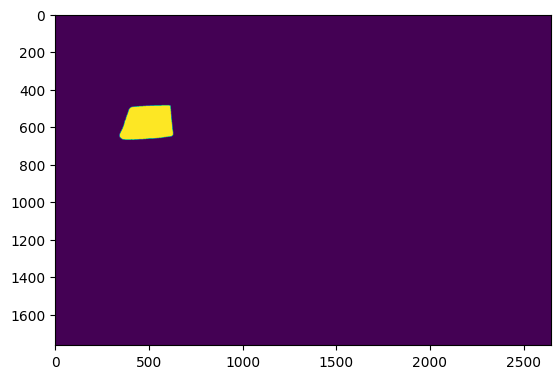

In [22]:
plt.imshow(masks.squeeze()[scores.argmax()])
plt.show()

# Outputs

In [23]:
import random

In [27]:
def get_output_masks(processor, model, i, input_points, device):
    inputs = processor(i, input_points=input_points, return_tensors="pt").to(device)
    image_embeddings = model.get_image_embeddings(inputs["pixel_values"])
    inputs.pop("pixel_values", None) # pixel_values are no more needed
    inputs.update({"image_embeddings": image_embeddings})
    with torch.no_grad():
        outputs = model(**inputs)
    masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())[0]
    scores = outputs.iou_scores
    return masks, scores
    
def get_input_point(i, l):
    # randomly pick an instance mask
    m = random.sample(l, 1)[0]
    c = m['category_id']
    m = annToMask(i, m)
    x_v, y_v = np.where(m >= 0)
    r = random.randint(0,len(x_v))
    x, y = x_v[r], y_v[r]
    return [[[y,x]]], c

In [28]:
def get_masks():

    name_list, mask_list, score_list, point_list, point_class_list = [], [], [], [], []
    for j, (i, l) in enumerate(train_loader):
        
        try: 
            print(l[0]['segmentation']['counts'])
            break
        except:
            pass

        # input_points, point_class = get_input_point(i, l)
        # # show_points_on_image(i[0], input_points[0])

        # masks, scores = get_output_masks(processor, model, i, input_points, device)
        # # show_masks_on_image(i[0], masks, scores)  
        
        # name_list.append(int(l[0]['image_id'].cpu().detach().numpy()))
        # mask_list.append(masks.squeeze()[scores.argmax()].cpu().detach().numpy())
        # score_list.append(float(scores.max().cpu().detach().numpy()))
        # point_list.append(input_points[0][0])
        # point_class_list.append(int(point_class))

    return name_list, point_list, point_class_list, mask_list, score_list

In [31]:
name, point, point_class, mask, score = get_masks()
name[0], point[0], point_class[0], mask[0], score[0]

/tmp/ipykernel_3563571/2831941643.py:11: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  rles = pycocotools.mask.frPyObjects(segm, h, w)
/tmp/ipykernel_3563571/2831941643.py:11: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  rles = pycocotools.mask.frPyObjects(segm, h, w)
/tmp/ipykernel_3563571/2831941643.py:15: FutureWarning: The input object of

ValueError: Sample larger than population or is negative

In [ ]:
# recover image name from image_id

In [20]:
import pandas as pd

In [21]:
df = pd.DataFrame({'name': name, 'point': point, 'class': point_class, 'mask': mask, 'score': score})

In [22]:
df.head()

,name,point,class,mask,score
0,139,"[40, 73]",86,"[[False, False, False, False, False, False, Fa...",1.003152
1,285,"[94, 35]",23,"[[False, False, False, False, False, False, Fa...",1.010332
2,632,"[608, 239]",84,"[[False, False, False, False, False, False, Fa...",1.027240
3,724,"[285, 258]",13,"[[False, False, False, False, False, False, Fa...",1.006332
4,776,"[0, 67]",65,"[[False, False, False, False, False, False, Fa...",1.008725


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   name    5 non-null      int64  
 1   point   5 non-null      object 
 2   class   5 non-null      int64  
 3   mask    5 non-null      object 
 4   score   5 non-null      float64
dtypes: float64(1), int64(2), object(2)
memory usage: 328.0+ bytes


array([[<AxesSubplot: title={'center': 'score'}>]], dtype=object)

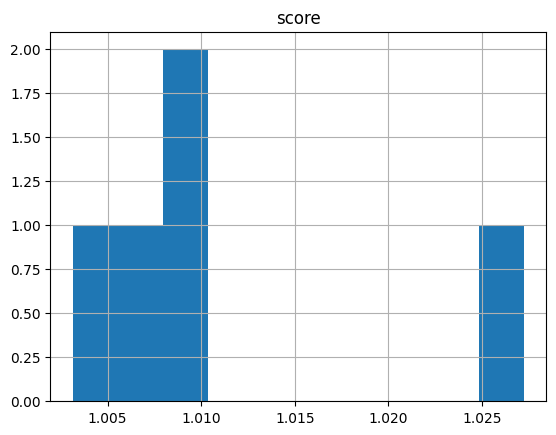

In [24]:
df.hist(column='score')

In [25]:
df[['name', 'point', 'class']].to_pickle("results/coco_prompts.pkl")

In [26]:
df[['name', 'point', 'class']]

,name,point,class
0,139,"[40, 73]",86
1,285,"[94, 35]",23
2,632,"[608, 239]",84
3,724,"[285, 258]",13
4,776,"[0, 67]",65


In [27]:
df = pd.read_pickle("results/coco_prompts.pkl")

In [28]:
df[df['name']==632][['point', 'class']].values[0][1]

84

# Metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle("results/coco_prompts.pkl")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4952 entries, 0 to 4951
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4952 non-null   int64 
 1   prompt  4952 non-null   object
 2   class   4952 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 116.2+ KB


In [12]:
df_0 = pd.read_pickle("results/coco_SAM_0.pkl")
df_10 = pd.read_pickle("results/coco_SAM_10.pkl") 
df_50 = pd.read_pickle("results/coco_SAM_0.pkl") #
df_75 = pd.read_pickle("results/coco_SAM_75.pkl")
df_80 = pd.read_pickle("results/coco_SAM_80.pkl")
df_90 = pd.read_pickle("results/coco_SAM_90.pkl")

In [19]:
CLASSES = {
1:	'person',	
2:	'bicycle',	
3:	'car',
4:	'motorcycle',	
5:	'airplane',
6:	'bus',
7:	'train',
8:	'truck',	
9:	'boat',
10:	'traffic light',	
11:	'fire hydrant',
12:	'street sign',	
13:	'stop sign',
14:	'parking meter',	
15:	'bench',	
16:	'bird',
17:	'cat',	
18:	'dog',
19:	'horse',
20:	'sheep',	
21:	'cow',
22:	'elephant',
23:	'bear',
24:	'zebra',
25:	'giraffe',
26:	'hat',
27:	'backpack',
28:	'umbrella',
29:	'shoe',
30:	'eye glasses',
31:	'handbag',	
32:	'tie',
33:	'suitcase',
34:	'frisbee',	
35:	'skis',
36:	'snowboard',
37:	'sports',
38:	'kite',
39:	'baseball bat',
40:	'baseball glove',	
41:	'skateboard',	
42:	'surfboard',
43:	'tennis racket',	
44:	'bottle',	
45:	'plate',
46:	'wine glass',	
47:	'cup',
48:	'fork',
49:	'knife',
50:	'spoon',
51:	'bowl',
52:	'banana',
53:	'apple',
54:	'sandwich',
55:	'orange',
56:	'broccoli',
57:	'carrot',
58:	'hot dog',	
59:	'pizza',
60:	'donut',
61:	'cake',
62:	'chair',
63:	'couch',
64:	'potted plant',
65:	'bed',
66:	'mirror',
67:	'dining table',
68:	'window',
69:	'desk',
70:	'toilet',
71:	'door',
72:	'tv',
73:	'laptop',
74:	'mouse',
75:	'remote',
76:	'keyboard',
77:	'cell phone',
78:	'microwave',
79:	'oven',
80:	'toaster',
81:	'sink',
82:	'refrigerator',
83:	'blender',
84:	'book',
85:	'clock',
86:	'vase',
87:	'scissors',
88: 'teddy bear',
89: 'hair drier',	
90: 'toothbrush',
91: 'hair brush'
}

def calculate_metrics(target, pred, eps=1e-5, verbose=False):

    if verbose:
        plt.subplot(1, 2, 1)
        plt.imshow(target)
        plt.subplot(1, 2, 2)
        plt.imshow(pred)
        plt.show()

    output = np.reshape(pred, -1)
    target = np.reshape(target, -1)

    tp = np.sum(output * target)  # TP (Intersection)
    un = np.sum(output + target)  # Union
    fp = np.sum(output * (~target))  # FP
    fn = np.sum((~output) * target)  # FN
    tn = np.sum((~output) * (~target))  # TN

    iou = (tp + eps) / (un + eps)
    pixel_acc = (tp + tn + eps) / (tp + tn + fp + fn + eps)
    dice = (2 * tp + eps) / (2 * tp + fp + fn + eps)
    precision = (tp + eps) / (tp + fp + eps)
    recall = (tp + eps) / (tp + fn + eps)
    specificity = (tn + eps) / (tn + fp + eps)

    if verbose:
        print(f"IoU: {iou:.4f}, Pixel Acc: {pixel_acc:.4f}, Dice: {dice:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Specificity: {specificity:.4f}")

    return iou, pixel_acc, dice, precision, specificity, recall

Class: book [84]
Prompt: [46, 398]
Score: 1.0098, 1.0098


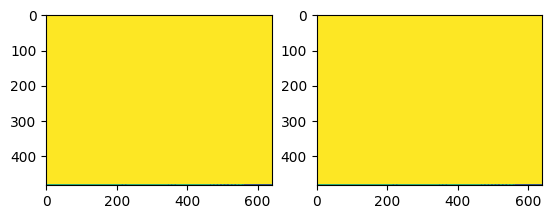

IoU: 1.0000, Pixel Acc: 1.0000, Dice: 1.0000, Precision: 1.0000, Recall: 1.0000, Specificity: 1.0000
Name: 632


In [20]:
idx = 2
s_0 = df_0.iloc[idx]
s_50 = df_50.iloc[idx]

c = s_0['class']
print(f"Class: {CLASSES[c]} [{c}]")
print(f"Prompt: {s_0['prompt']}")

print(f"Score: {s_0['score']:.4f}, {s_50['score']:.4f}")

i, a, d, p, r, s = calculate_metrics(s_0['mask'], s_50['mask'], verbose=True)
print(f"Name: {s_0['name']}")


In [ ]:
for j, (i, l, n) in enumerate(train_loader):
    if j == idx:
        break

In [ ]:
show_points_on_image(l[0], [[s_0['prompt'][0], s_0['prompt'][1]]])
show_points_on_image(i[0], [[s_0['prompt'][0], s_0['prompt'][1]]])
show_points_on_image(s_0['mask'], [[s_0['prompt'][0], s_0['prompt'][1]]])

l[0][s_0['prompt'][1], s_0['prompt'][0]]

In [ ]:
def get_analytics(target_df, pred_df):
    metrics = {k: [] for k in ['name', 'prompt', 'class', 'score', 'score_diff', 'mask_size', 'mask_size_diff',  'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']}
    for i in range(len(target_df)):
        target = target_df.loc[i]
        pred = pred_df.loc[i]

        iou, pixel_acc, dice, precision, specificity, recall = calculate_metrics(target['mask'], pred['mask'])
        
        metrics['name'].append(target['name'])
        metrics['prompt'].append(target['prompt'])
        metrics['class'].append(target['class'])
        metrics['score'].append(pred['score'])
        metrics['score_diff'].append((pred['score'] - target['score']) / (target['score'] + 1e-5))
        p_size = np.mean(pred['mask'].astype('float'))
        t_size = np.mean(target['mask'].astype('float'))
        metrics['mask_size'].append(p_size)
        metrics['mask_size_diff'].append((p_size - t_size) / (t_size + 1e-3))
        metrics['iou'].append(iou)
        metrics['pixel_acc'].append(pixel_acc)
        metrics['dice'].append(dice)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['specificity'].append(specificity)
    
    return pd.DataFrame(metrics)

In [ ]:
df = get_analytics(df_0, df_90)

In [ ]:
df.head()

In [ ]:
for k in ['class', 'score', 'score_diff', 'mask_size', 'mask_size_diff',  'iou', 'pixel_acc', 'dice', 'precision', 'recall', 'specificity']:
    s = pd.Series(df[k])
    fig, ax = plt.subplots()
    ax2 = ax.twinx()
    n, bins, patches = ax.hist(s, bins='auto')
    n, bins, patches = ax2.hist(s, cumulative=True, histtype='step', bins='auto', color='tab:orange', linewidth=2, density=True)
    plt.title(k)
    plt.show()